In [1]:
#Script to study the conservation of framework residues in the paratope and they difference of this between single domain and full length antibodies
#@author: Henriette Capel
#@Date: 18-05-2022

In [1]:
#Import modules
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import ast
from ABDB import database as db
import re
from collections import Counter
import Bio.PDB
from Bio.Data.IUPACData import protein_letters_3to1
from scipy.stats import chi2_contingency 
import scipy.stats as stats
#%load_ext nb_black

/Users/gemmagordon/opt/anaconda3/lib/python3.8/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


In [2]:
import logomaker as lm

In [3]:
# conda install -c bioconda logomaker

<IPython.core.display.Javascript object>

In [3]:
#Constants
binning_scheme = {
  'D':'F','E':'F','H':'E','K':'E','R':'E',
  'I':'A','L':'A','M':'C','P':'A','V':'A',
  'N':'G','Q':'G','C':'C','S':'D','T':'D',
  'A':'A','G':'A','F':'B','W':'B','Y':'B'
}

colour_palette_aa_group = {'A': 'lightgreen',
                          'B': 'mediumpurple',
                          'C': 'yellow',
                          'D': 'orange',
                          'E': 'blue',
                          'F': 'tomato',
                          'G': 'tab:cyan'}

all_positions_interest = sorted([66, 52, 55, 42, 50, 118, 69, 67, 40, 2])

In [4]:
all_positions_interest

[2, 40, 42, 50, 52, 55, 66, 67, 69, 118]

In [15]:
#Functions
def read_dataset(filename_ds):
    
    df = pd.read_csv(filename_ds, converters={i: str for i in range(100)})
    
    for colname in df.columns.values.tolist():
        try:
            df[colname] = [ast.literal_eval(d) for d in df[colname]]
        except:
            pass

    return df

def determine_complex_id(df_row):
    #Determine the pdb, antigen chain, and antibody chain of a given row of a dataframe
    pdb = df_row["pdb"]
    ag_chain = df_row["antigen_chain"]
    ab_chain = df_row["antibody_chain"]

    return pdb, ag_chain, ab_chain

def study_aa_decomposition_framework(df_ds: pd.DataFrame, position: int, binning_scheme: dict) -> pd.DataFrame:
    #This function determines which antibody-antigen complexes have a specific framework residue in the paratope and studies the amino acid at this position.
    #Per position, the amino acids are stored and assigned to a specific amino acid class (using the binning_scheme)
    #Note: this function only considers the positions that belong to the paratope
    
    dict_information = {'pdb': [], 'antigen_chain': [], 'antibody_chain': [], 'position': [], 'amino_acid': [], 'amino_acid_class': [], 'num_interactions': []}
                      
    for index,row in df_ds.iterrows():
        pdb, ag_chain, ab_chain = determine_complex_id(row)
        paratope_id_interactions = row['paratope_num_interactions']
        
        #Check if full length and if so, select 
        if len(ab_chain) ==2:
            paratope_id_interactions = paratope_id_interactions[ab_chain[0]]
            
        for key_id in paratope_id_interactions.keys():
            list_id = key_id.split("_")
            if int(list_id[1]) == position: #Check of the position number is the one we are interested in
                try:
                    position_id = f"{list_id[1]}_{list_id[2]}" #Store with insertion if insertion exist
                except IndexError: 
                    position_id = str(list_id[1]) #Store without insertion if it doesn't exist
                    
                aa = list_id[0]
                
                #Store all information in the general dataframe
                dict_information['pdb'].append(pdb)
                dict_information['antigen_chain'].append(ag_chain)
                dict_information['antibody_chain'].append(ab_chain)
                dict_information['position'].append(position_id)
                dict_information['amino_acid'].append(aa)
                dict_information['amino_acid_class'].append(binning_scheme[aa])
                dict_information['num_interactions'].append(paratope_id_interactions[key_id])
    #Make dataframe of the dictionary
    df_information = pd.DataFrame.from_dict(dict_information)
    
    return df_information   

def plot_frequency_occurence_aa(df_information_1, df_information_2, column_name, list_all_possibilities, xlabel, title):
    #this function plots the frequency of amino acid or amino acid type (indicated by "column_name") of dataset 1 and dataset 2
    
    #setup data
    dict_aa_freq_1 = count_occurence_aa_decomp(df_information_1, column_name)
    dict_aa_freq_2 = count_occurence_aa_decomp(df_information_2, column_name)
    
    #Make sure every possible amino acid is present in the dictionary and it is alphabeticaly sorted; to avoid problems with plotting
    dict_aa_freq_sorted_1 = add_missing_aa_to_sorted_dict(dict_aa_freq_1, list_all_possibilities)
    dict_aa_freq_sorted_2 = add_missing_aa_to_sorted_dict(dict_aa_freq_2, list_all_possibilities)
    
    #plot
    bar_plot(dict_aa_freq_sorted_1, dict_aa_freq_sorted_2, xlabel, title)
    return None

def add_missing_aa_to_sorted_dict(dict_aa_freq, list_all_possibilities):
    #this function adds the missing aa (or aa_types) to the dictionary and sorts the dictionary.
    list_missing_aa = list(set(list_all_possibilities)- set(dict_aa_freq.keys()))

    for aa in list_missing_aa:
        dict_aa_freq[aa] = 0.0
    
    #Sort alphabeticaly
    dict_aa_freq_sorted = dict(sorted(dict_aa_freq.items()))
    return dict_aa_freq_sorted

def count_occurence_aa_decomp(df_information_1, column_name):
    #This function counts the occurence of every amino acid or amino acid type (indicated by "column_name")
    #The counts are transformed to frequencies 
    dict_aa_count = dict(Counter(df_information_1[column_name].tolist()))
    dict_aa_freq = {k: v / total for total in (sum(dict_aa_count.values()),) for k, v in dict_aa_count.items()}

    return dict_aa_freq

#### Study amino acid decomposition of these framework residues of all complexes; even if not in the paratope
#Note, need to run through BioPython for this
def study_aa_decomposition_framework_all_complexes(df_ds: pd.DataFrame, position: int, binning_scheme: dict) -> pd.DataFrame:
    #This function determines the amino acid decomposition of a certain framework residue of all complexes in the dataset, independent of the amino acid is in the paratope
    #Per position, the amino acids are stored and assigned to a specific amino acid class (using the binning_scheme)
    #The output is similar to "study_aa_decomposition_framework" and thus gives a dataframe containing per IMGT position the amino acid (and type) information and its corresponding complex

    dict_information = {'pdb': [], 'antigen_chain': [], 'antibody_chain': [], 'position': [], 'amino_acid': [], 'amino_acid_class': []}
                      
    for index,row in df_ds.iterrows():
        pdb, ag_chain, ab_chain = determine_complex_id(row)
        
        #Determine the heavy chain if it is an full length antibody
        if len(ab_chain)==2:
            chain_given = ab_chain[0]
        else:
            chain_given = ab_chain
            
        #Find position by looping over BioPython
        dict_found_residues = find_aa_in_BioPython(pdb, chain_given, position)
        for found_key in dict_found_residues.keys():
            aa = dict_found_residues[found_key]
            position_id = found_key
            #Store all information in the general dataframe
            dict_information['pdb'].append(pdb)
            dict_information['antigen_chain'].append(ag_chain)
            dict_information['antibody_chain'].append(ab_chain)
            dict_information['position'].append(position_id)
            dict_information['amino_acid'].append(aa)
            dict_information['amino_acid_class'].append(binning_scheme[aa])
    #Make dataframe of the dictionary
    df_information = pd.DataFrame.from_dict(dict_information)
    
    return df_information   


def find_aa_in_BioPython(pdb: str, chain_given: str, position_given: int) -> dict:
    #this function loops through BioPython to select the amino acid corresponding to a certain position of a certain chain in a certain pdb. 
    #the output is a dictionary containing the position: amino_acid. It is stored in a dictionary to be able to allow insertions to be selected
    found_residues = {}
    
    print(pdb)
    p = db.fetch(pdb)
    imgt_structure = p.get_structure(scheme="imgt", definition = 'imgt')
    for model in imgt_structure:
        model_id = model.get_id()
        for chain_type in model:
            chain_type_id = chain_type.get_id()
            if chain_type_id != "Antigen":
                for chain in chain_type:
                    chain_id = chain.get_id()
                    if chain_id == chain_given:
                        #Now that we are in the correct chain. Loop over all the positions we need to find
                        for residue in chain:
                            res_id = residue.get_id()
                            res_position = res_id[1]
                            res_insertion = res_id[2]
                            
                            if int(res_position) == int(position_given):
                                res_name = residue.resname.strip()
                                try:  
                                    #Get 1 code amino acid name
                                    res_name_3code = res_name[0]+res_name[1:].lower() #Note: should start with upper case letter, all others lower case
                                    res_name_1code = Bio.Data.IUPACData.protein_letters_3to1[res_name_3code]
                                
                                    #Store
                                    if res_insertion != " ":
                                        residue_id_store = f"{res_position}_{res_insertion}"
                                    else:
                                        residue_id_store = str(res_position)
                                    found_residues[residue_id_store] = res_name_1code
                                except KeyError: 
                                    print(f"Residue 1D code could not be found: {pdb}, {chain_given}, {position}")
                                    print(residue)
                            elif int(res_position) > int(position_given):
                                return found_residues #Can already stop if residue position is higher. 
    return found_residues



def bar_plot(dict_aa_freq_sorted1, dict_aa_freq_sorted2, xlabel, title):
    #Note: 1 should be sdAbs, 2nd should be FlAbs
    if (dict_aa_freq_sorted1.keys() != dict_aa_freq_sorted2.keys()):
        print("WARNING: keys are not exactly the same (order of elements)")
    
    X = np.arange(max([len(dict_aa_freq_sorted1), len(dict_aa_freq_sorted2)]))
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    width = 0.4

    ax.bar(X, np.array(list(dict_aa_freq_sorted1.values())), color = "mediumblue", label="SdAb", width = width)
    ax.bar(X + width, np.array(list(dict_aa_freq_sorted2.values())), color = "red", label="FlAb", width = width)
     
    plt.xticks(X, dict_aa_freq_sorted1.keys())
    plt.xlabel(f"{xlabel}")
    plt.ylabel("Observed fraction in paratope")
    plt.legend()
    plt.ylim((0.0, 1.05))
    # plt.title(f"{title}")
    plt.show()
    #plt.savefig(f'aa_decomp_framework_paratope_{title}.png', bbox_inches='tight')
    

### Sequence logos
def create_info_for_sequence_logo(df_ds, binning_scheme, list_positions, ds = "nb", set_to_determine = "paratope", classification = "amino_acid_class"):
    #This function determines the occurence of every amino acid class (or amino acid; determined by "classification") in a certain position for a certain dataset.
    #Note: for the "general" type we need to open the predetermined files containing the dataset information
    df_collect_info = pd.DataFrame(columns = ["position"] + sorted(list(set(binning_scheme.values()))))
    df_collect_info_counts = pd.DataFrame(columns = ["position"] + sorted(list(set(binning_scheme.values()))))
    
    for position in list_positions:
        if set_to_determine == "paratope":
            df_temp = study_aa_decomposition_framework(df_ds, position, binning_scheme)
        elif set_to_determine == "general":
            df_temp = read_dataset(f"Framework_{position}_aa_{ds}.csv")
        else:
            print(f"WARNING: name {set_to_determine} not recognised")
        
        #If dataset is empty set all fractions to zero
        if df_temp.empty:
            print(f'DataFrame is empty for position: {position}')
            dict_fraction_occurence = {}
            dict_count= {}
            for aa_type in sorted(list(set(binning_scheme.values()))):
                dict_fraction_occurence[aa_type] = [0.0]
                dict_count[aa_type] = [0]
        else: 
            dict_count_occurence = dict(Counter(df_temp[classification].tolist()))
            dict_fraction_occurence = {k: [v / total] for total in (sum(dict_count_occurence.values()),) for k, v in dict_count_occurence.items()}
            dict_count = {k: [v] for k, v in dict_count_occurence.items()}
        dict_fraction_occurence["position"] = position #Add position to the dictionary
        dict_count["position"] = position #Add position to the dictionary
    
        df_line = pd.DataFrame.from_dict(dict_fraction_occurence) #Make a line of a dataframe
        df_collect_info = pd.concat([df_collect_info, df_line]) #Combine this new line with the previously stored information. 
        
        #Do same for the counts dataframe
        df_line_count = pd.DataFrame.from_dict(dict_count) #Make a line of a dataframe
        df_collect_info_counts = pd.concat([df_collect_info_counts, df_line_count]) #Combine this new line with the previously stored information. 
        
    return df_collect_info, df_collect_info_counts

def make_sequence_logo(df_info, list_positions, binning_scheme, colour_palette_aa_group):
    #Function to make sequence logo figure of a dataframe in which for each position the fraction of all amino acid (classes) are stored
    
    #set index; such that only these positions in plot instead of min-max
    df_info = df_info.reset_index()
    
    #Convert NAN to 0.0
    df_info = df_info.fillna(0.0)
    
    #Make figure
    logo = lm.Logo(df_info[sorted(list(set(binning_scheme.values())))], color_scheme = colour_palette_aa_group, stack_order='small_on_top')#, font_name = 'Arial Rounded MT Bold')
    
    #Improve figure
    #Give the right labels to plot
    logo.ax.set_xticks(range(len(df_info)))
    logo.ax.set_xticklabels(x for x in list_positions) 
    logo.ax.set_ylabel("Normalised frequency")
    logo.ax.set_xlabel("IMGT positions")
    # plt.savefig(f'seqlogo_fv_paratope.png', bbox_inches='tight')
    
#Stacked plot differences
### difference
def setup_data_plot_difference_stacked(dict_info_ds1, dict_info_ds2):
    #This function represents the dictionary of a specific cdr_type containing a dictionary with the amino acid type as keys and list of fractions of occurence in the different positions as values. the order of these positions is stored in the key "positions".
    #For each position and each amino acid type the difference between the single domain antibodies and the full length antibodies is calculated.
    
    #Store dictionary in dataframe
    df1 = pd.DataFrame(dict_info_ds1)
    df1 = df1.set_index('position')
    df1 = df1.fillna(0.0)
    df1 = df1.loc[~(df1==0).all(axis=1)] #Remove positions if never seen in paratope

    df2 = pd.DataFrame(dict_info_ds2)
    df2 = df2.set_index('position')
    df2 = df2.fillna(0.0)
    
    #Determine difference between df1 and df2
    df_difference = df1.subtract(df2)
    df_difference.dropna(inplace=True)
    df_difference = df_difference.reindex(df1.index.tolist())

    #Set to numpy to make plot creation easier
    df_transpose = df_difference.T
    np_differences = df_transpose.to_numpy()
    order_aagroups = list(df_difference.columns)

    data_shape = np.shape(np_differences)

    # Take negative and positive data apart and cumulate
    cumulated_data = get_cumulated_array(np_differences, min=0)
    cumulated_data_neg = get_cumulated_array(np_differences, max=0)

    # Re-merge negative and positive data.
    row_mask = (np_differences<0)
    cumulated_data[row_mask] = cumulated_data_neg[row_mask]
    data_stack = cumulated_data
    
    return np_differences, df_difference, data_stack, data_shape, order_aagroups
    
def get_cumulated_array(data, **kwargs):
    #Function needed to make stacked difference plot
    cum = data.clip(**kwargs)
    cum = np.cumsum(cum, axis=0)
    d = np.zeros(np.shape(data))
    d[1:] = cum[:-1]
    return d 


def plotting_differences_stacked(np_differences, df_difference, data_stack, data_shape, list_aa_groupnames, colour_palette, figure_title):
    labels = list(df_difference.index.values)
    labels_str = [str(x) for x in labels] 

    fig = plt.figure()
    ax = plt.subplot(111)
    
    #order the amino acids groups such that always the same order in all different plots
    #Need copy first because .sort() will overwrite the list and we still need to be able to access the old order
    order_list_aa_groupnames = list_aa_groupnames.copy()
    order_list_aa_groupnames.sort()
    
    dict_description_AA_class = {"A": "aliphatic", "B": "aromatic", "C": "sulfur", "D": "hydroxyl", "E": "basic", "F": "acidic", "G": "amine"}
    
    for aa in order_list_aa_groupnames:
        #Assign the right index for np_differences and data_stack
        index = list_aa_groupnames.index(aa)
        bar = ax.bar(labels_str, np_differences[index], bottom=data_stack[index], color=colour_palette[aa], label = f"{aa}: {dict_description_AA_class[aa]}")
        
    ax.set_xticklabels(labels_str,  fontsize = 12)
    ax.set_xlabel("IMGT position",  fontsize = 12)
    ax.set_ylabel('Difference of observed fractions', fontsize = 12)
    ax.set_ylim([-0.6, 0.6])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),  fontsize = 12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.title(f"{figure_title}")
    
    plt.show()
    
#### Chi squared test
# The chi-square test tests the null hypothesis that the categorical data has the given frequencies.
def perform_chi_squared(paratope_distribution, general_distribution):

    #Remove the position if expected (general distribution zero)
    general_distribution = np.array(general_distribution)
    paratope_distribution = np.array(paratope_distribution)[general_distribution != 0].tolist()
    general_distribution = general_distribution[general_distribution != 0].tolist()
    
    print(f"counts paratope removed zero expected: {paratope_distribution}")
    print(f"counts general removed zero expected: {general_distribution}")
    
    #Create table
    table = np.array([paratope_distribution,
                  general_distribution])
    
    #perform chi squared test
    chi2, p, dof, expected = chi2_contingency(table)
    
    #print output
    print(f"chi2 statistic:     {chi2:.5g}")
    print(f"p-value:            {p:.5g}")
    print(f"degrees of freedom: {dof}")
    print("expected frequencies:")

    return None

def determine_chi_squared(df_paratope, df_general):
    #this function takes as input the dataframe containing the information of the paratope distribution and a dataframe containing information about the general distribution.
    #Both dataframe should belong to the same dataset. Besides we need to dataframe in which the raw counts are stored in order to check if we may perform the chi squared test
    #the dataframe stores per position (rows) the normalised frequency of observing a specific amino acid
    #this function will print the chi-squared results per position
    #Note: if chi-square test is not allowed perform the Fisher's exact test in R (only possible way to do it for multiple classes)
    
    #Clean the dataframes
    df_paratope = clean_df(df_paratope)
    df_general = clean_df(df_general)
    
    for index, row in df_paratope.iterrows():
        print(f"Position: {index}")
        paratope_count_list = list(row)
        total_samples_paratope = sum(paratope_count_list)
        
        #Check if more than minimum number of samples
        if total_samples_paratope < 13:
            print(f"Chi squared should not be determined as number of total samples < 13: {total_samples_paratope} \n")
            continue
        general_count_list = df_general.loc[[index]].values.flatten().tolist()
        
        print(f"counts paratope: {paratope_count_list}")
        print(f"counts general: {general_count_list}")
        perform_chi_squared(paratope_count_list, general_count_list)
        print("\n")
        # perform_bernard_test(paratope_count_list, general_count_list)
    return df_paratope, df_general
        
    
def clean_df(df):
    #convert column 'position' to index and change "nan" with 0.0
    df = df.set_index('position')
    df = df.fillna(0.0)
    return df
    


In [6]:
#Read datasets (after filtering on hetero atoms)
#Single domain antibodies
ds_name_arp_nb = '/Users/gemmagordon/Documents/OXFORD/ROTATION 2/henriette/vhh-vh-epitope-comparison/Dataset_nb_arpeggio_interactions.csv' #"Dataset_nb_arpeggio_interactions.csv"
df_arp_nb = read_dataset(ds_name_arp_nb)

#Full length
ds_name_arp_fv = '/Users/gemmagordon/Documents/OXFORD/ROTATION 2/henriette/vhh-vh-epitope-comparison/Dataset_fv_arpeggio_interactions.csv'#"Dataset_fv_arpeggio_interactions.csv"
df_arp_fv = read_dataset(ds_name_arp_fv)

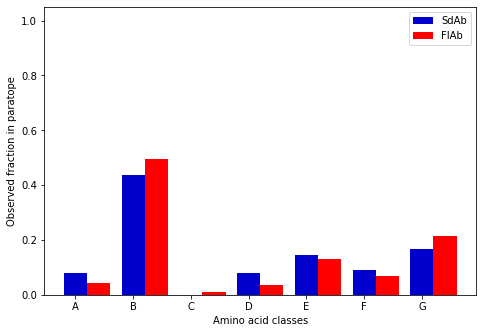

<IPython.core.display.Javascript object>

In [7]:
##Study position 66
position = 66
plot_frequency_occurence_aa(study_aa_decomposition_framework(df_arp_nb, position, binning_scheme), study_aa_decomposition_framework(df_arp_fv, position, binning_scheme) , "amino_acid_class", sorted(set(binning_scheme.values())), "Amino acid classes", f"{position}")


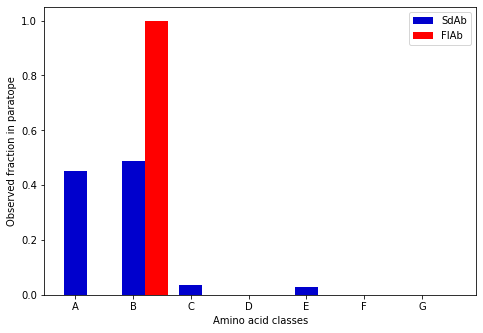

<IPython.core.display.Javascript object>

In [8]:
##Study position 52
position = 52
plot_frequency_occurence_aa(study_aa_decomposition_framework(df_arp_nb, position, binning_scheme), study_aa_decomposition_framework(df_arp_fv, position, binning_scheme) , "amino_acid_class", sorted(set(binning_scheme.values())), "Amino acid classes", f"{position}")


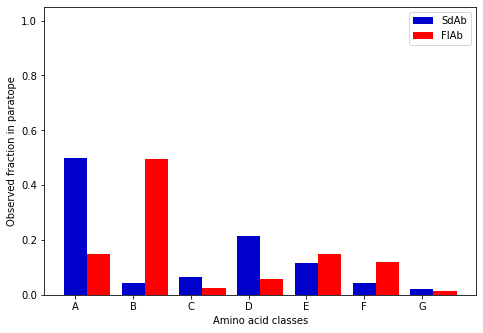

<IPython.core.display.Javascript object>

In [9]:
##Study position 55
position = 55
plot_frequency_occurence_aa(study_aa_decomposition_framework(df_arp_nb, position, binning_scheme), study_aa_decomposition_framework(df_arp_fv, position, binning_scheme) , "amino_acid_class", sorted(set(binning_scheme.values())), "Amino acid classes", f"{position}")


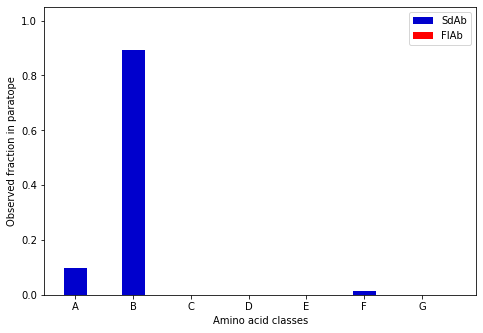

<IPython.core.display.Javascript object>

In [10]:
##Study position 42
position = 42
plot_frequency_occurence_aa(study_aa_decomposition_framework(df_arp_nb, position, binning_scheme), study_aa_decomposition_framework(df_arp_fv, position, binning_scheme) , "amino_acid_class", sorted(set(binning_scheme.values())), "Amino acid classes", f"{position}")


In [11]:
study_aa_decomposition_framework(df_arp_nb, 42, binning_scheme)

,pdb,antigen_chain,antibody_chain,position,amino_acid,amino_acid_class,num_interactions
0,5ja9,C,A,42,Y,B,3
1,4u3x,B,A,42,V,A,1
2,7t5f,A,C,42,Y,B,2
3,7m1h,A,D,42,Y,B,2
4,7m1h,A,E,42,F,B,1
...,...,...,...,...,...,...,...
78,5j1s,B,C,42,Y,B,1
79,6gjs,A,C,42,Y,B,2
80,4x7f,B,D,42,Y,B,2
81,4bel,B,E,42,V,A,1


<IPython.core.display.Javascript object>

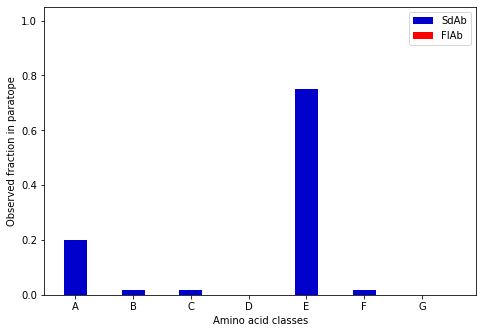

<IPython.core.display.Javascript object>

In [12]:
##Study position 50
position = 50
plot_frequency_occurence_aa(study_aa_decomposition_framework(df_arp_nb, position, binning_scheme), study_aa_decomposition_framework(df_arp_fv, position, binning_scheme) , "amino_acid_class", sorted(set(binning_scheme.values())), "Amino acid classes", f"{position}")


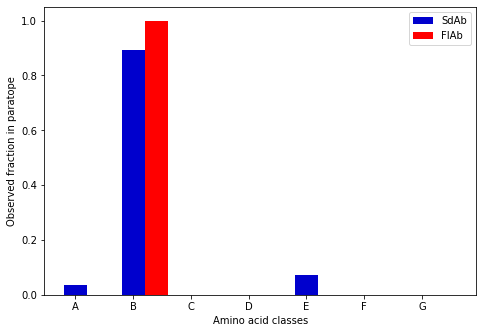

<IPython.core.display.Javascript object>

In [13]:
##Study position 118
position = 118
plot_frequency_occurence_aa(study_aa_decomposition_framework(df_arp_nb, position, binning_scheme), study_aa_decomposition_framework(df_arp_fv, position, binning_scheme) , "amino_acid_class", sorted(set(binning_scheme.values())), "Amino acid classes", f"{position}")


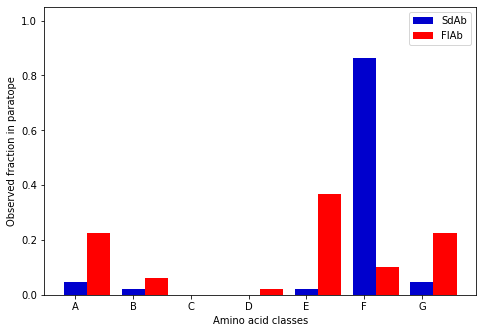

<IPython.core.display.Javascript object>

In [14]:
##Study position 69
position = 69
plot_frequency_occurence_aa(study_aa_decomposition_framework(df_arp_nb, position, binning_scheme), study_aa_decomposition_framework(df_arp_fv, position, binning_scheme) , "amino_acid_class", sorted(set(binning_scheme.values())), "Amino acid classes", f"{position}")


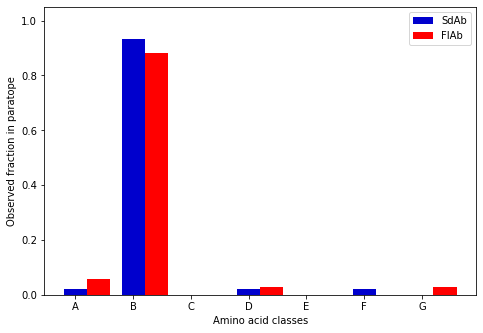

<IPython.core.display.Javascript object>

In [15]:
##Study position 67
position = 67
plot_frequency_occurence_aa(study_aa_decomposition_framework(df_arp_nb, position, binning_scheme), study_aa_decomposition_framework(df_arp_fv, position, binning_scheme) , "amino_acid_class", sorted(set(binning_scheme.values())), "Amino acid classes", f"{position}")


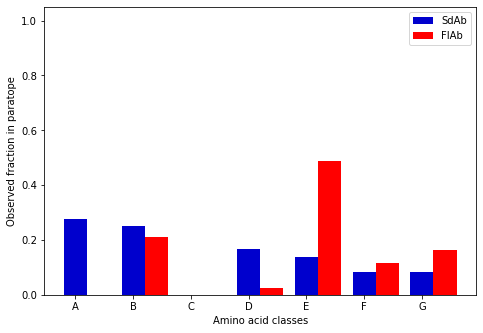

<IPython.core.display.Javascript object>

In [16]:
##Study position 40
position = 40
plot_frequency_occurence_aa(study_aa_decomposition_framework(df_arp_nb, position, binning_scheme), study_aa_decomposition_framework(df_arp_fv, position, binning_scheme) , "amino_acid_class", sorted(set(binning_scheme.values())), "Amino acid classes", f"{position}")


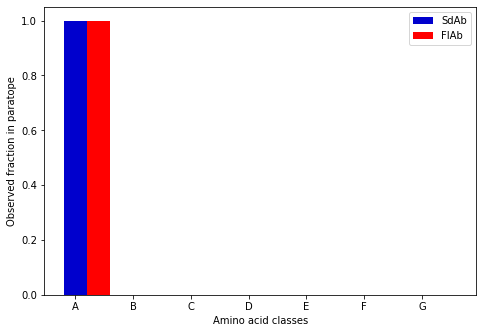

<IPython.core.display.Javascript object>

In [17]:
##Study position 2
position = 2
plot_frequency_occurence_aa(study_aa_decomposition_framework(df_arp_nb, position, binning_scheme), study_aa_decomposition_framework(df_arp_fv, position, binning_scheme) , "amino_acid_class", sorted(set(binning_scheme.values())), "Amino acid classes", f"{position}")


##### Determine general decomposition over all seqeunces in the datasets

In [16]:
position = 66
df_all_66_nb = study_aa_decomposition_framework_all_complexes(df_arp_nb, position, binning_scheme)
df_all_66_fv = study_aa_decomposition_framework_all_complexes(df_arp_fv, position, binning_scheme)
# df_all_66_nb.to_csv(f"Framework_{position}_aa_nb.csv", index=False)
# df_all_66_fv.to_csv(f"Framework_{position}_aa_fv.csv", index=False)

#Load if previously stored
# df_all_66_nb = read_dataset(f"Framework_{position}_aa_nb.csv")
# df_all_66_fv = read_dataset(f"Framework_{position}_aa_fv.csv")
plot_frequency_occurence_aa(df_all_66_nb, df_all_66_fv, "amino_acid_class", sorted(set(binning_scheme.values())), "Amino acid classes", f"{position}")

7qiv


AttributeError: 'NoneType' object has no attribute 'get_structure'

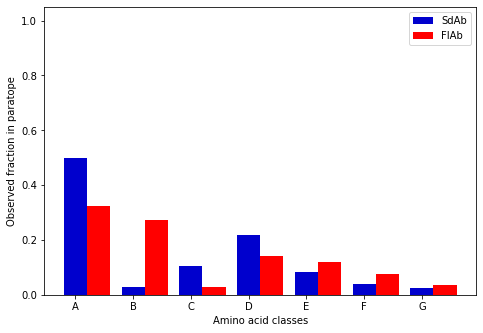

<IPython.core.display.Javascript object>

In [20]:
position = 55
# df_all_nb = study_aa_decomposition_framework_all_complexes(df_arp_nb, position, binning_scheme)
# df_all_fv = study_aa_decomposition_framework_all_complexes(df_arp_fv, position, binning_scheme)
# df_all_nb.to_csv(f"Framework_{position}_aa_nb.csv", index=False)
# df_all_fv.to_csv(f"Framework_{position}_aa_fv.csv", index=False)

#Load if previously stored
df_all_nb = read_dataset(f"Framework_{position}_aa_nb.csv")
df_all_fv = read_dataset(f"Framework_{position}_aa_fv.csv")
plot_frequency_occurence_aa(df_all_nb, df_all_fv, "amino_acid_class", sorted(set(binning_scheme.values())), "Amino acid classes", f"{position}")

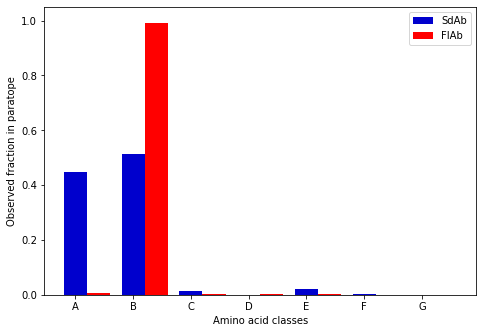

<IPython.core.display.Javascript object>

In [21]:
position = 52
# df_all_nb = study_aa_decomposition_framework_all_complexes(df_arp_nb, position, binning_scheme)
# df_all_fv = study_aa_decomposition_framework_all_complexes(df_arp_fv, position, binning_scheme)
# df_all_nb.to_csv(f"Framework_{position}_aa_nb.csv", index=False)
# df_all_fv.to_csv(f"Framework_{position}_aa_fv.csv", index=False)

#Load if previously stored
df_all_nb = read_dataset(f"Framework_{position}_aa_nb.csv")
df_all_fv = read_dataset(f"Framework_{position}_aa_fv.csv")
plot_frequency_occurence_aa(df_all_nb, df_all_fv, "amino_acid_class", sorted(set(binning_scheme.values())), "Amino acid classes", f"{position}")


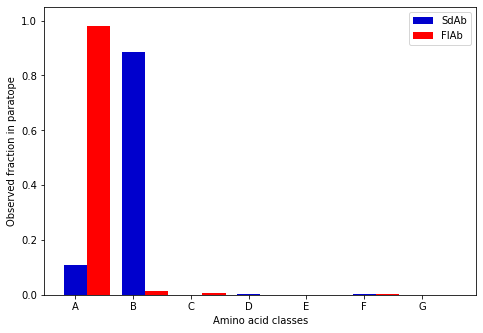

<IPython.core.display.Javascript object>

In [22]:
position = 42
# df_all_nb = study_aa_decomposition_framework_all_complexes(df_arp_nb, position, binning_scheme)
# df_all_fv = study_aa_decomposition_framework_all_complexes(df_arp_fv, position, binning_scheme)
# df_all_nb.to_csv(f"Framework_{position}_aa_nb.csv", index=False)
# df_all_fv.to_csv(f"Framework_{position}_aa_fv.csv", index=False)

#Load if previously stored
df_all_nb = read_dataset(f"Framework_{position}_aa_nb.csv")
df_all_fv = read_dataset(f"Framework_{position}_aa_fv.csv")
plot_frequency_occurence_aa(df_all_nb, df_all_fv, "amino_acid_class", sorted(set(binning_scheme.values())), "Amino acid classes", f"{position}")

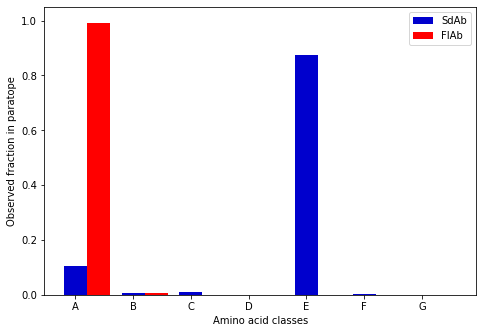

<IPython.core.display.Javascript object>

In [23]:
position = 50
# df_all_nb = study_aa_decomposition_framework_all_complexes(df_arp_nb, position, binning_scheme)
# df_all_fv = study_aa_decomposition_framework_all_complexes(df_arp_fv, position, binning_scheme)
# df_all_nb.to_csv(f"Framework_{position}_aa_nb.csv", index=False)
# df_all_fv.to_csv(f"Framework_{position}_aa_fv.csv", index=False)

#Load if previously stored
df_all_nb = read_dataset(f"Framework_{position}_aa_nb.csv")
df_all_fv = read_dataset(f"Framework_{position}_aa_fv.csv")
plot_frequency_occurence_aa(df_all_nb, df_all_fv, "amino_acid_class", sorted(set(binning_scheme.values())), "Amino acid classes", f"{position}")

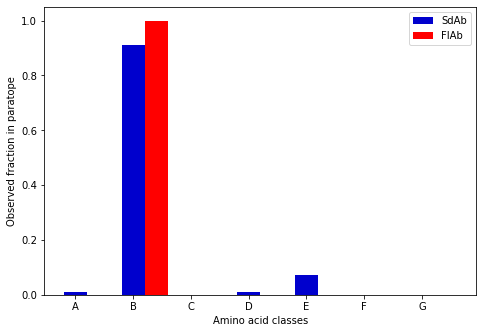

<IPython.core.display.Javascript object>

In [24]:
position = 118
# df_all_nb = study_aa_decomposition_framework_all_complexes(df_arp_nb, position, binning_scheme)
# df_all_fv = study_aa_decomposition_framework_all_complexes(df_arp_fv, position, binning_scheme)
# df_all_nb.to_csv(f"Framework_{position}_aa_nb.csv", index=False)
# df_all_fv.to_csv(f"Framework_{position}_aa_fv.csv", index=False)

#Load if previously stored
df_all_nb = read_dataset(f"Framework_{position}_aa_nb.csv")
df_all_fv = read_dataset(f"Framework_{position}_aa_fv.csv")
plot_frequency_occurence_aa(df_all_nb, df_all_fv, "amino_acid_class", sorted(set(binning_scheme.values())), "Amino acid classes", f"{position}")

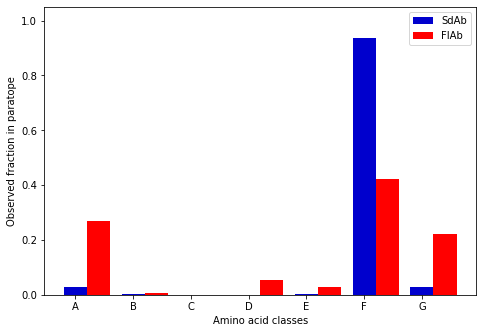

<IPython.core.display.Javascript object>

In [25]:
position = 69
# df_all_nb = study_aa_decomposition_framework_all_complexes(df_arp_nb, position, binning_scheme)
# df_all_fv = study_aa_decomposition_framework_all_complexes(df_arp_fv, position, binning_scheme)
# df_all_nb.to_csv(f"Framework_{position}_aa_nb.csv", index=False)
# df_all_fv.to_csv(f"Framework_{position}_aa_fv.csv", index=False)

#Load if previously stored
df_all_nb = read_dataset(f"Framework_{position}_aa_nb.csv")
df_all_fv = read_dataset(f"Framework_{position}_aa_fv.csv")
plot_frequency_occurence_aa(df_all_nb, df_all_fv, "amino_acid_class", sorted(set(binning_scheme.values())), "Amino acid classes", f"{position}")

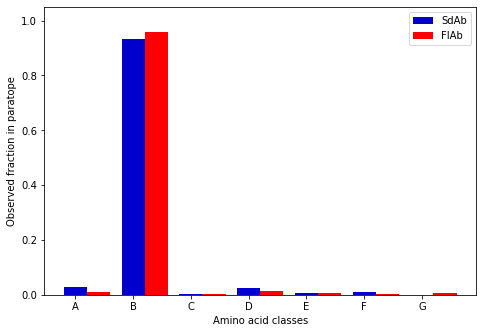

<IPython.core.display.Javascript object>

In [26]:
position = 67
# df_all_nb = study_aa_decomposition_framework_all_complexes(df_arp_nb, position, binning_scheme)
# df_all_fv = study_aa_decomposition_framework_all_complexes(df_arp_fv, position, binning_scheme)
# df_all_nb.to_csv(f"Framework_{position}_aa_nb.csv", index=False)
# df_all_fv.to_csv(f"Framework_{position}_aa_fv.csv", index=False)

#Load if previously stored
df_all_nb = read_dataset(f"Framework_{position}_aa_nb.csv")
df_all_fv = read_dataset(f"Framework_{position}_aa_fv.csv")
plot_frequency_occurence_aa(df_all_nb, df_all_fv, "amino_acid_class", sorted(set(binning_scheme.values())), "Amino acid classes", f"{position}")

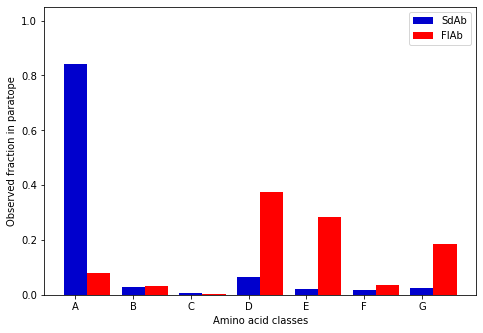

<IPython.core.display.Javascript object>

In [27]:
position = 40
# df_all_nb = study_aa_decomposition_framework_all_complexes(df_arp_nb, position, binning_scheme)
# df_all_fv = study_aa_decomposition_framework_all_complexes(df_arp_fv, position, binning_scheme)
# df_all_nb.to_csv(f"Framework_{position}_aa_nb.csv", index=False)
# df_all_fv.to_csv(f"Framework_{position}_aa_fv.csv", index=False)

#Load if previously stored
df_all_nb = read_dataset(f"Framework_{position}_aa_nb.csv")
df_all_fv = read_dataset(f"Framework_{position}_aa_fv.csv")
plot_frequency_occurence_aa(df_all_nb, df_all_fv, "amino_acid_class", sorted(set(binning_scheme.values())), "Amino acid classes", f"{position}")


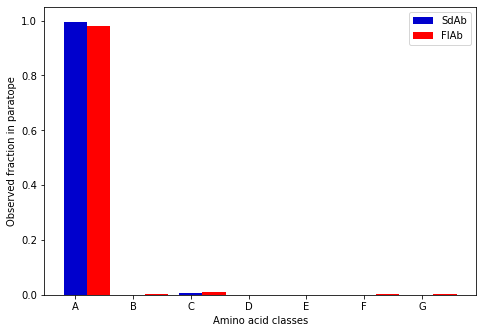

<IPython.core.display.Javascript object>

In [28]:
position = 2
# df_all_nb = study_aa_decomposition_framework_all_complexes(df_arp_nb, position, binning_scheme)
# df_all_fv = study_aa_decomposition_framework_all_complexes(df_arp_fv, position, binning_scheme)
# df_all_nb.to_csv(f"Framework_{position}_aa_nb.csv", index=False)
# df_all_fv.to_csv(f"Framework_{position}_aa_fv.csv", index=False)

#Load if previously stored
df_all_nb = read_dataset(f"Framework_{position}_aa_nb.csv")
df_all_fv = read_dataset(f"Framework_{position}_aa_fv.csv")
plot_frequency_occurence_aa(df_all_nb, df_all_fv, "amino_acid_class", sorted(set(binning_scheme.values())), "Amino acid classes", f"{position}")


In [29]:
#### Study all amino acids, not only classes

<IPython.core.display.Javascript object>

In [30]:
#Only paratopes

<IPython.core.display.Javascript object>

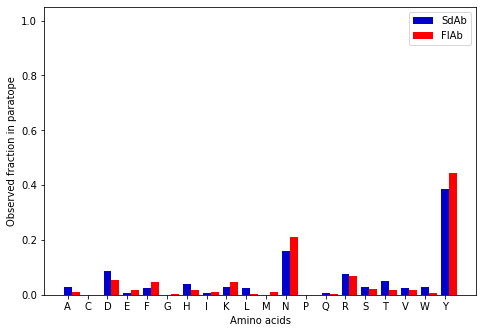

<IPython.core.display.Javascript object>

In [31]:
##Study position 66
position = 66
plot_frequency_occurence_aa(study_aa_decomposition_framework(df_arp_nb, position, binning_scheme), study_aa_decomposition_framework(df_arp_fv, position, binning_scheme) , "amino_acid", sorted(set(binning_scheme.keys())), "Amino acids", f"{position}")

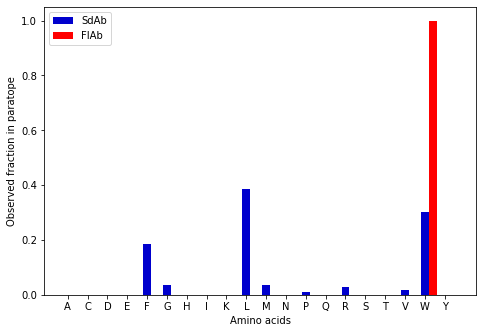

<IPython.core.display.Javascript object>

In [32]:
##Study position 52
position = 52
plot_frequency_occurence_aa(study_aa_decomposition_framework(df_arp_nb, position, binning_scheme), study_aa_decomposition_framework(df_arp_fv, position, binning_scheme) , "amino_acid", sorted(set(binning_scheme.keys())), "Amino acids", f"{position}")

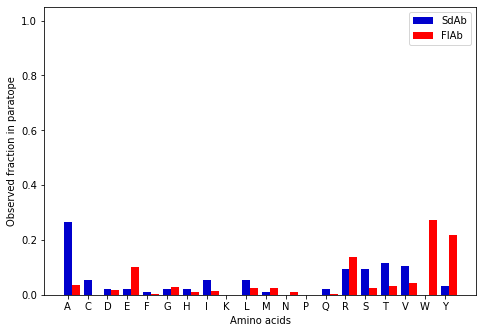

<IPython.core.display.Javascript object>

In [33]:
##Study position 55
position = 55
plot_frequency_occurence_aa(study_aa_decomposition_framework(df_arp_nb, position, binning_scheme), study_aa_decomposition_framework(df_arp_fv, position, binning_scheme) , "amino_acid", sorted(set(binning_scheme.keys())), "Amino acids", f"{position}")

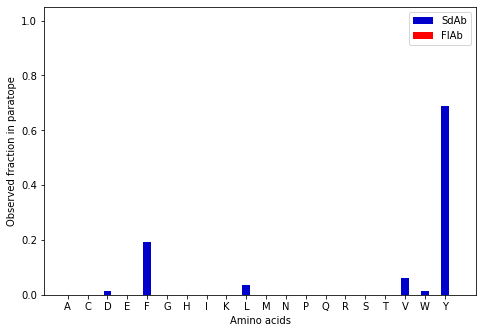

<IPython.core.display.Javascript object>

In [34]:
##Study position 42
position = 42
plot_frequency_occurence_aa(study_aa_decomposition_framework(df_arp_nb, position, binning_scheme), study_aa_decomposition_framework(df_arp_fv, position, binning_scheme) , "amino_acid", sorted(set(binning_scheme.keys())), "Amino acids", f"{position}")

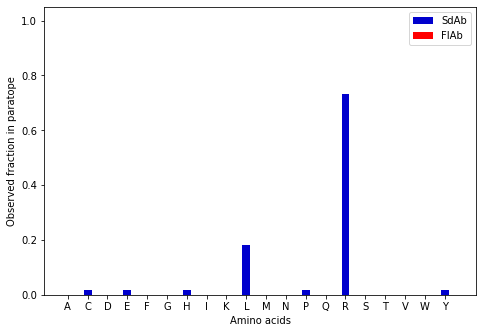

<IPython.core.display.Javascript object>

In [35]:
##Study position 50
position = 50
plot_frequency_occurence_aa(study_aa_decomposition_framework(df_arp_nb, position, binning_scheme), study_aa_decomposition_framework(df_arp_fv, position, binning_scheme) , "amino_acid", sorted(set(binning_scheme.keys())), "Amino acids", f"{position}")

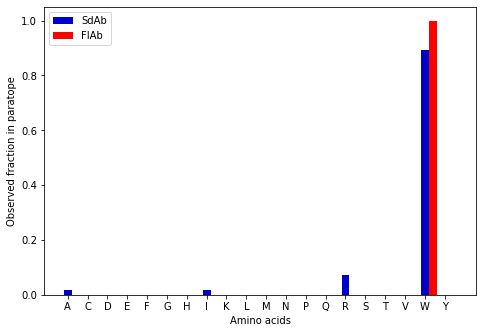

<IPython.core.display.Javascript object>

In [36]:
##Study position 118
position = 118
plot_frequency_occurence_aa(study_aa_decomposition_framework(df_arp_nb, position, binning_scheme), study_aa_decomposition_framework(df_arp_fv, position, binning_scheme) , "amino_acid", sorted(set(binning_scheme.keys())), "Amino acids", f"{position}")

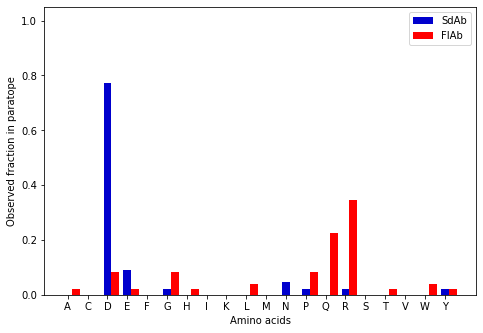

<IPython.core.display.Javascript object>

In [37]:
##Study position 69
position = 69
plot_frequency_occurence_aa(study_aa_decomposition_framework(df_arp_nb, position, binning_scheme), study_aa_decomposition_framework(df_arp_fv, position, binning_scheme) , "amino_acid", sorted(set(binning_scheme.keys())), "Amino acids", f"{position}")

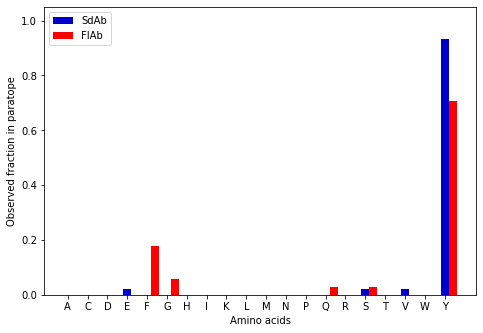

<IPython.core.display.Javascript object>

In [38]:
##Study position 67
position = 67
plot_frequency_occurence_aa(study_aa_decomposition_framework(df_arp_nb, position, binning_scheme), study_aa_decomposition_framework(df_arp_fv, position, binning_scheme) , "amino_acid", sorted(set(binning_scheme.keys())), "Amino acids", f"{position}")

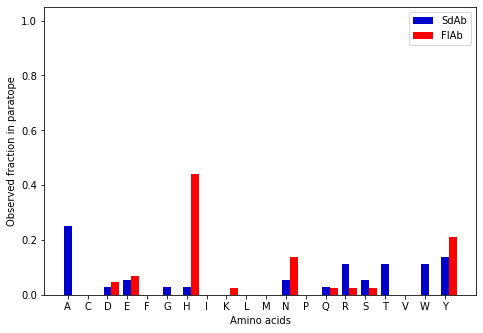

<IPython.core.display.Javascript object>

In [39]:
##Study position 40
position = 40
plot_frequency_occurence_aa(study_aa_decomposition_framework(df_arp_nb, position, binning_scheme), study_aa_decomposition_framework(df_arp_fv, position, binning_scheme) , "amino_acid", sorted(set(binning_scheme.keys())), "Amino acids", f"{position}")

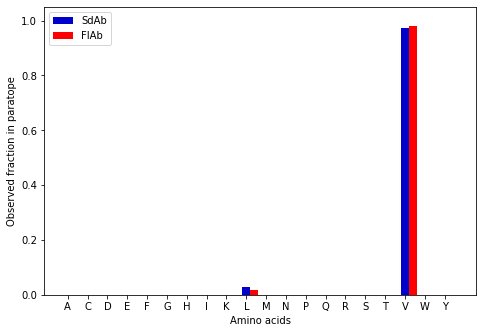

<IPython.core.display.Javascript object>

In [40]:
##Study position 2
position = 2
plot_frequency_occurence_aa(study_aa_decomposition_framework(df_arp_nb, position, binning_scheme), study_aa_decomposition_framework(df_arp_fv, position, binning_scheme) , "amino_acid", sorted(set(binning_scheme.keys())), "Amino acids", f"{position}")

In [41]:
## ALL sequences

<IPython.core.display.Javascript object>

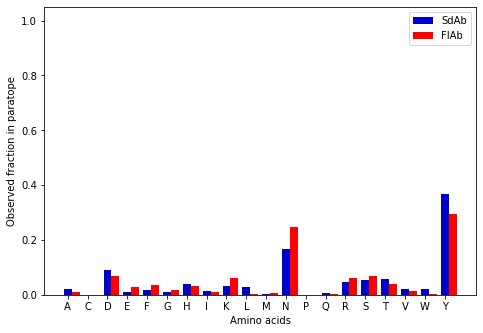

<IPython.core.display.Javascript object>

In [42]:
position = 66
df_all_66_nb = read_dataset(f"Framework_{position}_aa_nb.csv")
df_all_66_fv = read_dataset(f"Framework_{position}_aa_fv.csv")
plot_frequency_occurence_aa(df_all_66_nb, df_all_66_fv, "amino_acid", sorted(set(binning_scheme.keys())), "Amino acids", f"{position}")


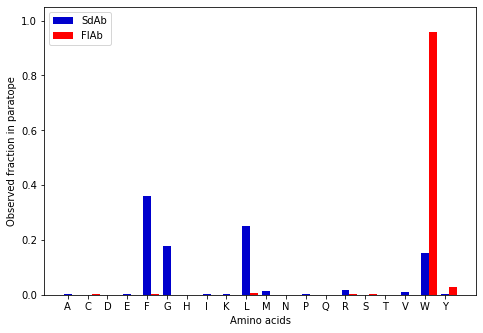

<IPython.core.display.Javascript object>

In [43]:
position = 52
df_all_nb = read_dataset(f"Framework_{position}_aa_nb.csv")
df_all_fv = read_dataset(f"Framework_{position}_aa_fv.csv")
plot_frequency_occurence_aa(df_all_nb, df_all_fv, "amino_acid", sorted(set(binning_scheme.keys())), "Amino acids", f"{position}")


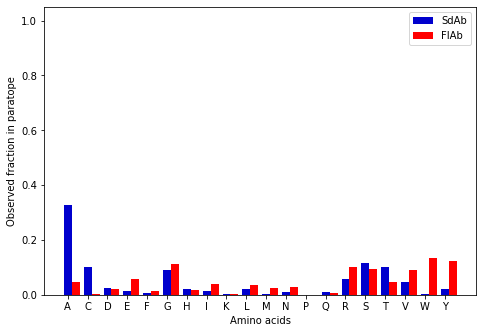

<IPython.core.display.Javascript object>

In [44]:
position = 55
df_all_nb = read_dataset(f"Framework_{position}_aa_nb.csv")
df_all_fv = read_dataset(f"Framework_{position}_aa_fv.csv")
plot_frequency_occurence_aa(df_all_nb, df_all_fv, "amino_acid", sorted(set(binning_scheme.keys())), "Amino acids", f"{position}")


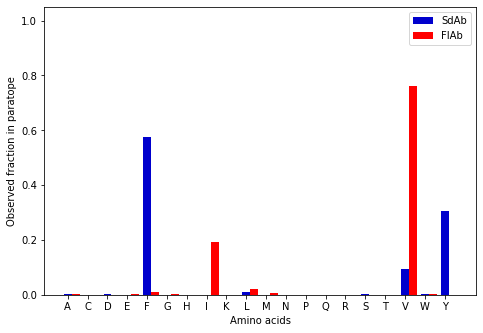

<IPython.core.display.Javascript object>

In [45]:
position = 42
df_all_nb = read_dataset(f"Framework_{position}_aa_nb.csv")
df_all_fv = read_dataset(f"Framework_{position}_aa_fv.csv")
plot_frequency_occurence_aa(df_all_nb, df_all_fv, "amino_acid", sorted(set(binning_scheme.keys())), "Amino acids", f"{position}")


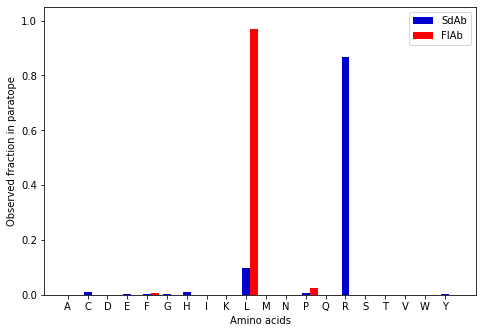

<IPython.core.display.Javascript object>

In [46]:
position = 50
df_all_nb = read_dataset(f"Framework_{position}_aa_nb.csv")
df_all_fv = read_dataset(f"Framework_{position}_aa_fv.csv")
plot_frequency_occurence_aa(df_all_nb, df_all_fv, "amino_acid", sorted(set(binning_scheme.keys())), "Amino acids", f"{position}")


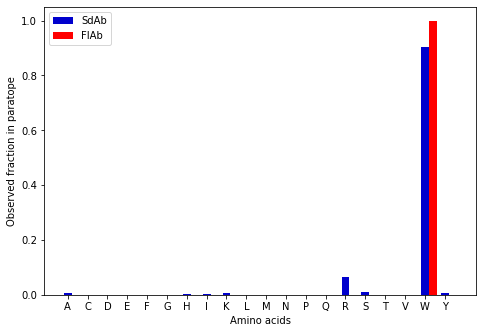

<IPython.core.display.Javascript object>

In [47]:
position = 118
df_all_nb = read_dataset(f"Framework_{position}_aa_nb.csv")
df_all_fv = read_dataset(f"Framework_{position}_aa_fv.csv")
plot_frequency_occurence_aa(df_all_nb, df_all_fv, "amino_acid", sorted(set(binning_scheme.keys())), "Amino acids", f"{position}")


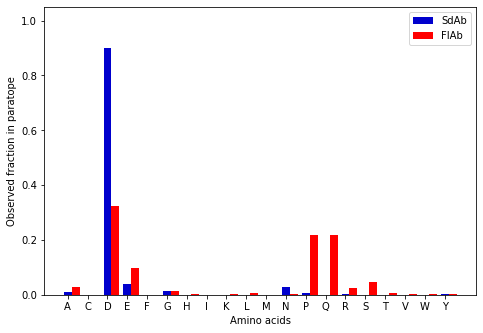

<IPython.core.display.Javascript object>

In [48]:
position = 69
df_all_nb = read_dataset(f"Framework_{position}_aa_nb.csv")
df_all_fv = read_dataset(f"Framework_{position}_aa_fv.csv")
plot_frequency_occurence_aa(df_all_nb, df_all_fv, "amino_acid", sorted(set(binning_scheme.keys())), "Amino acids", f"{position}")


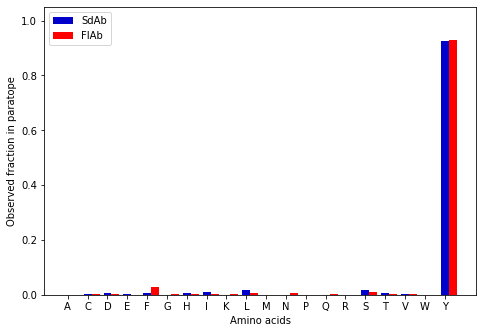

<IPython.core.display.Javascript object>

In [49]:
position = 67
df_all_nb = read_dataset(f"Framework_{position}_aa_nb.csv")
df_all_fv = read_dataset(f"Framework_{position}_aa_fv.csv")
plot_frequency_occurence_aa(df_all_nb, df_all_fv, "amino_acid", sorted(set(binning_scheme.keys())), "Amino acids", f"{position}")


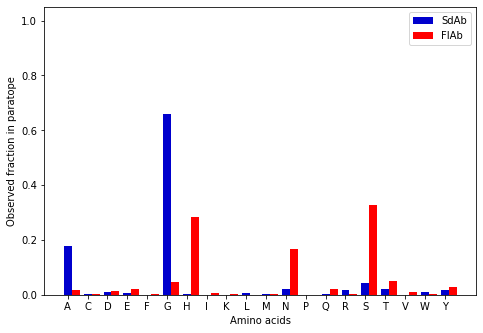

<IPython.core.display.Javascript object>

In [50]:
position = 40
df_all_nb = read_dataset(f"Framework_{position}_aa_nb.csv")
df_all_fv = read_dataset(f"Framework_{position}_aa_fv.csv")
plot_frequency_occurence_aa(df_all_nb, df_all_fv, "amino_acid", sorted(set(binning_scheme.keys())), "Amino acids", f"{position}")


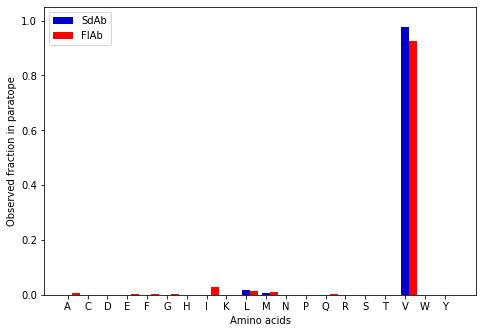

<IPython.core.display.Javascript object>

In [51]:
position = 2
df_all_nb = read_dataset(f"Framework_{position}_aa_nb.csv")
df_all_fv = read_dataset(f"Framework_{position}_aa_fv.csv")
plot_frequency_occurence_aa(df_all_nb, df_all_fv, "amino_acid", sorted(set(binning_scheme.keys())), "Amino acids", f"{position}")


In [52]:
##### SEQUENCE LOGOS

<IPython.core.display.Javascript object>

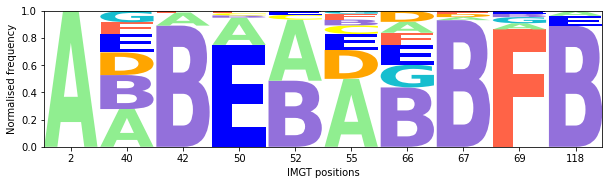

In [9]:
#single domain antibodies paratope
df_sl_paratope_nb, df_sl_paratope_count_nb = create_info_for_sequence_logo(df_arp_nb, binning_scheme, all_positions_interest)
make_sequence_logo(df_sl_paratope_nb, all_positions_interest, binning_scheme, colour_palette_aa_group)

In [10]:
#Single domain antibodies general
df_sl_general_nb, df_sl_general_count_nb = create_info_for_sequence_logo(df_arp_nb, binning_scheme, all_positions_interest, ds = "nb", set_to_determine = "general", classification = "amino_acid_class")
make_sequence_logo(df_sl_general_nb, all_positions_interest, binning_scheme, colour_palette_aa_group)

FileNotFoundError: [Errno 2] No such file or directory: 'Framework_2_aa_nb.csv'

DataFrame is empty for position: 42
DataFrame is empty for position: 50


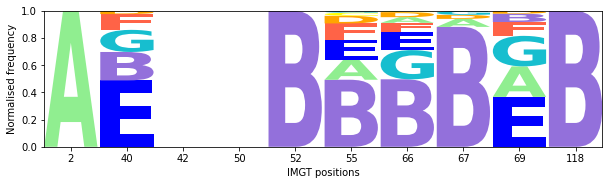

In [11]:
#full length antibodies paratope
df_sl_paratope_fv, df_sl_paratope_count_fv = create_info_for_sequence_logo(df_arp_fv, binning_scheme, all_positions_interest, ds = "fv")
make_sequence_logo(df_sl_paratope_fv, all_positions_interest, binning_scheme, colour_palette_aa_group)

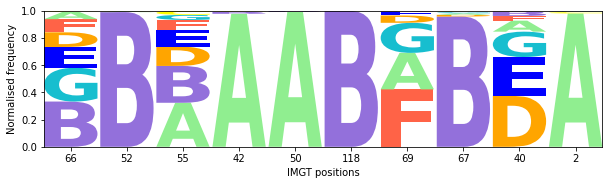

<IPython.core.display.Javascript object>

In [56]:
#full length antibodies general
df_sl_general_fv, df_sl_general_count_fv = create_info_for_sequence_logo(df_arp_fv, binning_scheme, all_positions_interest, ds = "fv", set_to_determine = "general", classification = "amino_acid_class")
make_sequence_logo(df_sl_general_fv, all_positions_interest, binning_scheme, colour_palette_aa_group)

In [57]:
##### Stacked plot differences

<IPython.core.display.Javascript object>

/data/icarus/capel/miniconda3/envs/minor_internship/lib/python3.10/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
/tmp/ipykernel_3185095/1014239995.py:322: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str,  fontsize = 12)


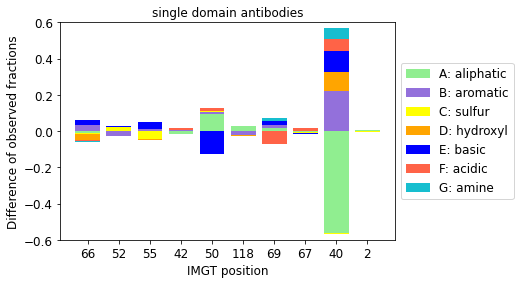

<IPython.core.display.Javascript object>

In [58]:
np_differences_nb, df_difference_nb, data_stack_nb, data_shape_nb, order_aagroups_nb = setup_data_plot_difference_stacked(df_sl_paratope_nb, df_sl_general_nb)
plotting_differences_stacked(np_differences_nb, df_difference_nb, data_stack_nb, data_shape_nb, order_aagroups_nb, colour_palette_aa_group, "single domain antibodies")


/data/icarus/capel/miniconda3/envs/minor_internship/lib/python3.10/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
/tmp/ipykernel_3185095/1014239995.py:322: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str,  fontsize = 12)


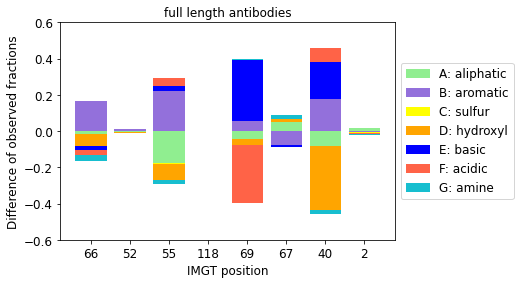

<IPython.core.display.Javascript object>

In [59]:
np_differences_fv, df_difference_fv, data_stack_fv, data_shape_fv, order_aagroups_fv = setup_data_plot_difference_stacked(df_sl_paratope_fv, df_sl_general_fv)
plotting_differences_stacked(np_differences_fv, df_difference_fv, data_stack_fv, data_shape_fv, order_aagroups_fv, colour_palette_aa_group, "full length antibodies")


In [60]:
#Statistical test if decomposition in paratope is subsample of general distribution or if enrichment of amino acid is observed    

<IPython.core.display.Javascript object>

In [61]:
df_paratope_nb, df_general_nb = determine_chi_squared(df_sl_paratope_count_nb, df_sl_general_count_nb)

Position: 66
counts paratope: [14.0, 76.0, 0.0, 14.0, 25.0, 16.0, 29.0]
counts general: [32.0, 139.0, 1.0, 39.0, 40.0, 34.0, 59.0]
counts paratope removed zero expected: [14.0, 76.0, 0.0, 14.0, 25.0, 16.0, 29.0]
counts general removed zero expected: [32.0, 139.0, 1.0, 39.0, 40.0, 34.0, 59.0]
chi2 statistic:     2.9964
p-value:            0.80929
degrees of freedom: 6
expected frequencies:


Position: 52
counts paratope: [49.0, 53.0, 4.0, 0.0, 3.0, 0.0, 0.0]
counts general: [155.0, 177.0, 5.0, 0.0, 7.0, 1.0, 0.0]
counts paratope removed zero expected: [49.0, 53.0, 4.0, 3.0, 0.0]
counts general removed zero expected: [155.0, 177.0, 5.0, 7.0, 1.0]
chi2 statistic:     2.6903
p-value:            0.61092
degrees of freedom: 4
expected frequencies:


Position: 55
counts paratope: [47.0, 4.0, 6.0, 20.0, 11.0, 4.0, 2.0]
counts general: [171.0, 10.0, 36.0, 75.0, 28.0, 14.0, 8.0]
counts paratope removed zero expected: [47.0, 4.0, 6.0, 20.0, 11.0, 4.0, 2.0]
counts general removed zero expected: [1

/data/icarus/capel/miniconda3/envs/minor_internship/lib/python3.10/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


<IPython.core.display.Javascript object>

In [62]:
df_paratope_fv, df_general_fv = determine_chi_squared(df_sl_paratope_count_fv, df_sl_general_count_fv)

Position: 66
counts paratope: [18.0, 215.0, 4.0, 16.0, 57.0, 30.0, 93.0]
counts general: [49.0, 296.0, 5.0, 96.0, 136.0, 86.0, 221.0]
counts paratope removed zero expected: [18.0, 215.0, 4.0, 16.0, 57.0, 30.0, 93.0]
counts general removed zero expected: [49.0, 296.0, 5.0, 96.0, 136.0, 86.0, 221.0]
chi2 statistic:     43.923
p-value:            7.6553e-08
degrees of freedom: 6
expected frequencies:


Position: 52
counts paratope: [0.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0]
counts general: [5.0, 882.0, 1.0, 1.0, 1.0, 0.0, 0.0]
counts paratope removed zero expected: [0.0, 49.0, 0.0, 0.0, 0.0]
counts general removed zero expected: [5.0, 882.0, 1.0, 1.0, 1.0]
chi2 statistic:     0.44423
p-value:            0.9787
degrees of freedom: 4
expected frequencies:


Position: 55
counts paratope: [45.0, 150.0, 7.0, 17.0, 45.0, 36.0, 4.0]
counts general: [288.0, 241.0, 26.0, 127.0, 106.0, 68.0, 33.0]
counts paratope removed zero expected: [45.0, 150.0, 7.0, 17.0, 45.0, 36.0, 4.0]
counts general removed zero

/data/icarus/capel/miniconda3/envs/minor_internship/lib/python3.10/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


<IPython.core.display.Javascript object>

In [63]:
# #Save to file
# df_paratope_nb.to_csv("df_framework_paratope_sdAb.csv")
# df_general_nb.to_csv("df_framework_general_sdAb.csv")
# df_paratope_fv.to_csv("df_framework_paratope_flAb.csv")
# df_general_fv.to_csv("df_framework_general_flAb.csv")

<IPython.core.display.Javascript object>